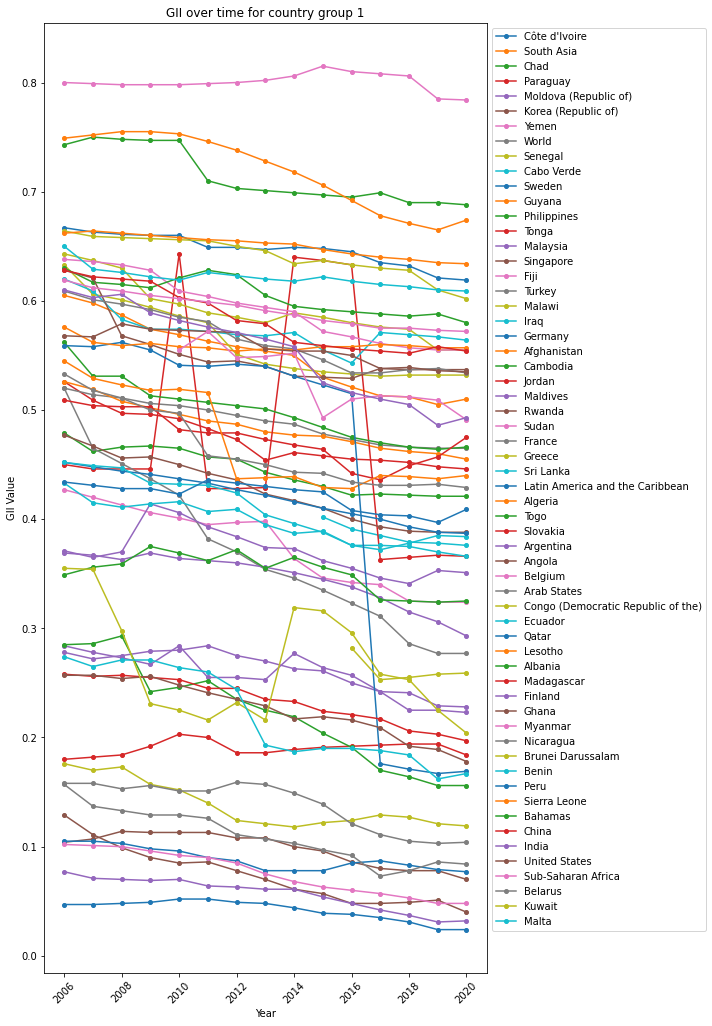

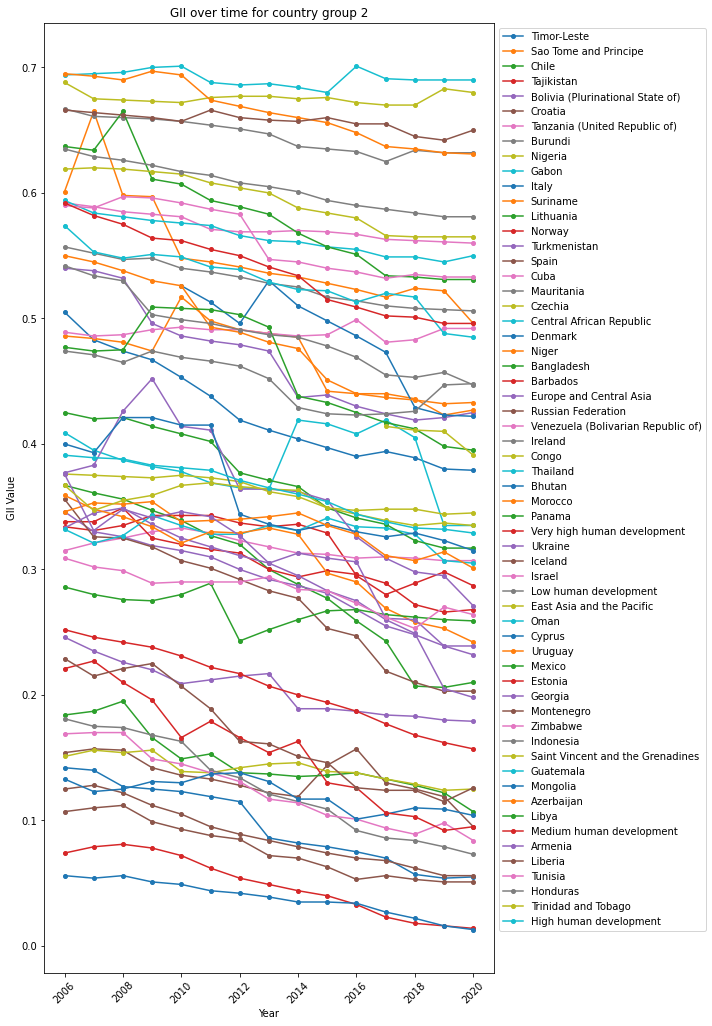

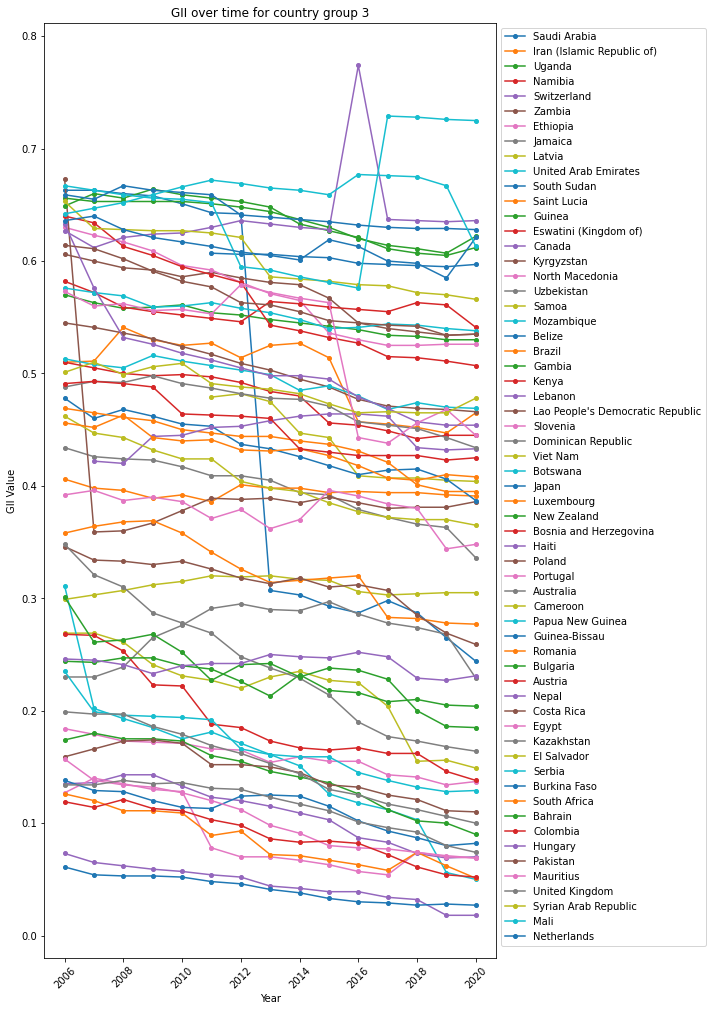

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt


spark = SparkSession.builder.appName("GIIAnalysis").getOrCreate()
def read_csv(filename):
    try:
        df = spark.read.csv(filename, header=True, inferSchema=True)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def plot_gii_time_scatter(df):
    df_melted = df.selectExpr("country", 
                              "stack(15, '2006', gii_2006, '2007', gii_2007, '2008', gii_2008, '2009', gii_2009, '2010', gii_2010, '2011', gii_2011, '2012', gii_2012, '2013', gii_2013, '2014', gii_2014, '2015', gii_2015, '2016', gii_2016, '2017', gii_2017, '2018', gii_2018, '2019', gii_2019, '2020', gii_2020) as (year, gii)")
    df_melted = df_melted.withColumn("year", col("year").cast("int")).na.drop()

    

    countries = [row.country for row in df_melted.select("country").distinct().collect()]
    num_countries = len(countries)
    split1 = countries[:num_countries // 3]
    split2 = countries[num_countries // 3: 2 * num_countries // 3]
    split3 = countries[2 * num_countries // 3:]

    splits = [split1, split2, split3]


    for idx, split in enumerate(splits, 1):
        plt.figure(figsize=(10, 15))
        for country in split:
            country_data = df_melted.filter(col("country") == country).orderBy("year")
            
            # Split data into consecutive groups for plotting
            consecutive_groups = []
            current_group = []
            prev_year = None
            for row in country_data.collect():
                if prev_year is None or row.year == prev_year + 1:
                    current_group.append((row.year, row.gii))
                else:
                    consecutive_groups.append(current_group)
                    current_group = [(row.year, row.gii)]
                prev_year = row.year
            consecutive_groups.append(current_group)
            
            # Plot consecutive data points
            for group in consecutive_groups:
                years, giis = zip(*group)
                plt.plot(years, giis, label=country, marker='o', markersize=4, linestyle='-')

        plt.title(f'GII over time for country group {idx}')
        plt.xlabel('Year')
        plt.ylabel('GII Value')
        plt.xticks(rotation=45)
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    filename = "Alldata.csv"
    df = read_csv(filename)
    plot_gii_time_scatter(df)


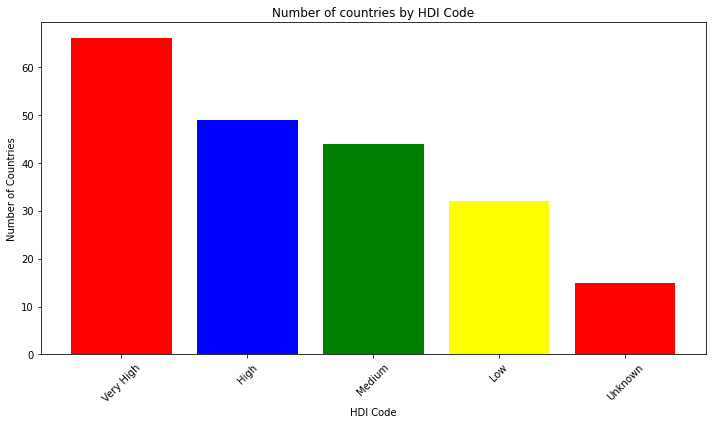

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt


spark = SparkSession.builder.appName("DataAnalysis").getOrCreate()

def read_csv(filename):
    try:
        df = spark.read.csv(filename, header=True, inferSchema=True)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

from pyspark.sql.functions import when

def plot_hdicode_histogram(df):
    counts = df.groupBy("hdicode").count().orderBy("count", ascending=False)
    counts = counts.fillna(0).withColumn("hdicode", when(col("hdicode").isNull(), "Unknown").otherwise(col("hdicode")))
    
    counts_df = counts.toPandas()
    plt.figure(figsize=(10, 6))
    plt.bar(counts_df['hdicode'], counts_df['count'], color=['red', 'blue', 'green', 'yellow'])
    plt.title('Number of countries by HDI Code')
    plt.xlabel('HDI Code')
    plt.ylabel('Number of Countries')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    filename = "Alldata.csv"
    df = read_csv(filename)
    if df is not None:
        plot_hdicode_histogram(df)


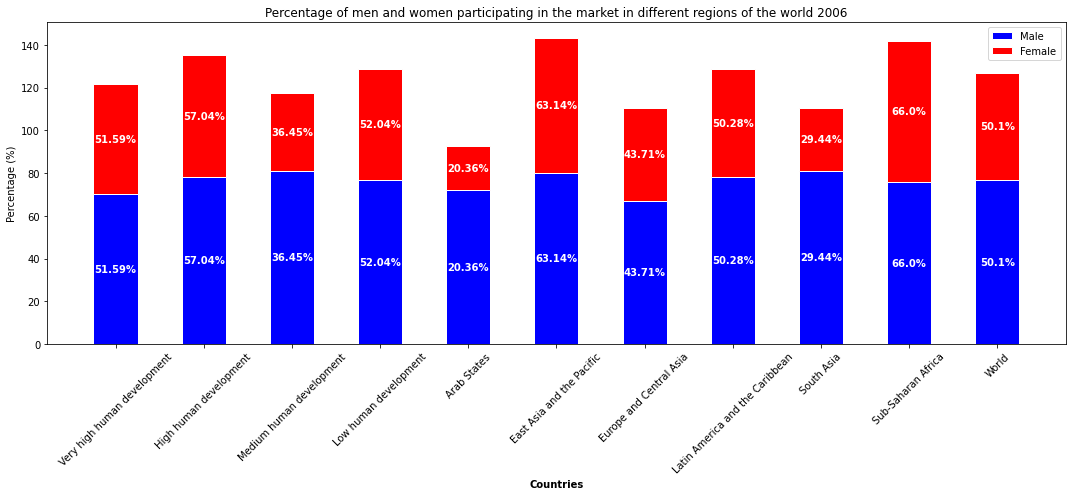

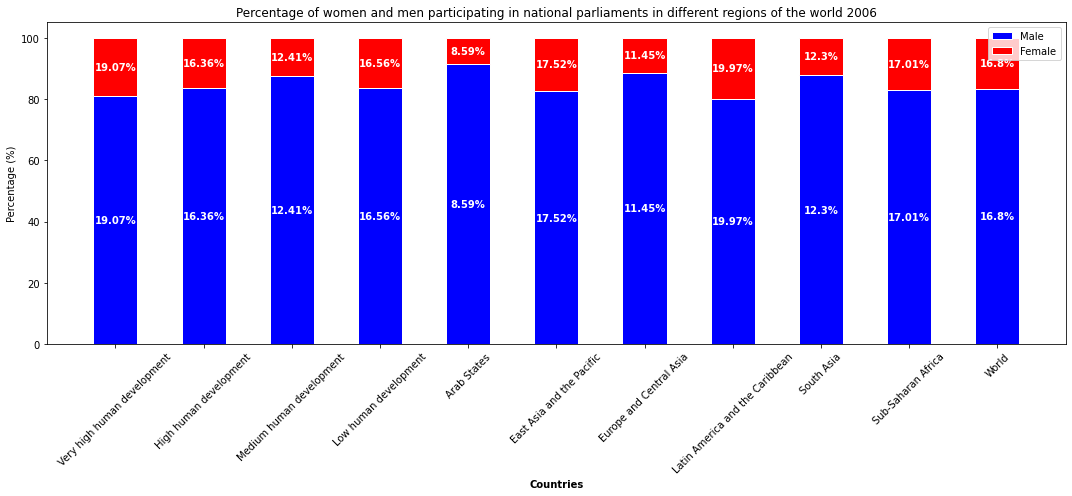

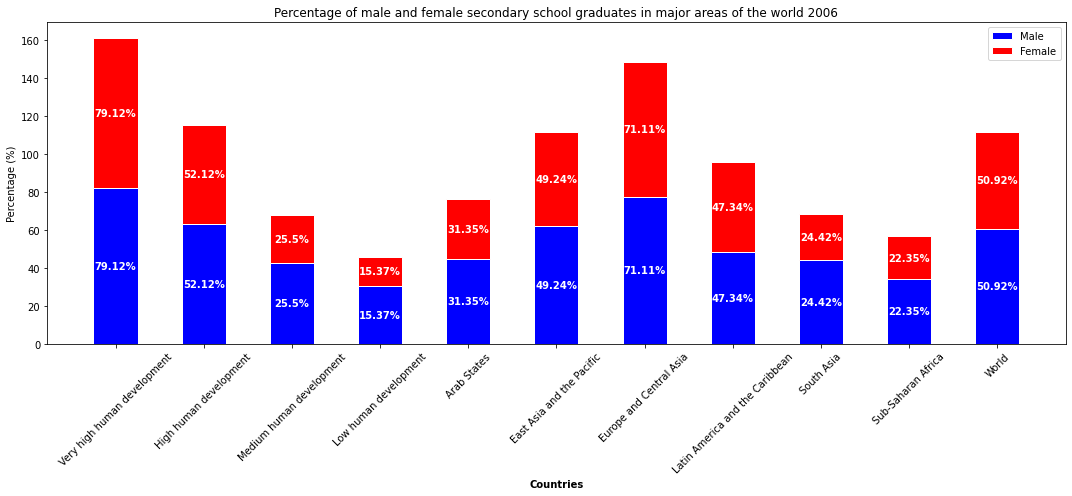

In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt


spark = SparkSession.builder.appName("GIIAnalysis").getOrCreate()

def read_csv(filename):
    try:
        df = spark.read.csv(filename, header=True, inferSchema=True)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def plot_parliament_gender_distribution_by_year(df):
    years = list(range(2006, 2007))

    categories = {
        'Market Participation': {
            'female': 'lfpr_f_{}',
            'male': 'lfpr_m_{}',
            'title': 'Percentage of men and women participating in the market in different regions of the world {}'
        },
        'Parliament Participation': {
            'female': 'pr_f_{}',
            'male': 'pr_m_{}',
            'title': 'Percentage of women and men participating in national parliaments in different regions of the world {}'
        },
        'Secondary School Graduation': {
            'female': 'se_f_{}',
            'male': 'se_m_{}',
            'title': 'Percentage of male and female secondary school graduates in major areas of the world {}'
        }
    }

    countries_to_select = [
        "Very high human development",
        "High human development",
        "Medium human development",
        "Low human development",
        "Arab States",
        "East Asia and the Pacific",
        "Europe and Central Asia",
        "Latin America and the Caribbean",
        "South Asia",
        "Sub-Saharan Africa",
        "World"
    ]

    for year in years:
        for category, data in categories.items():
            pr_f_column = data['female'].format(year)
            pr_m_column = data['male'].format(year)

            df_filtered = df.filter(col("country").isin(countries_to_select)).select("country", pr_f_column, pr_m_column).na.drop()

            countries = [row.country for row in df_filtered.select("country").collect()]
            pr_f_values = [row[pr_f_column] for row in df_filtered.collect() if row[pr_f_column] is not None]
            pr_m_values = [row[pr_m_column] for row in df_filtered.collect() if row[pr_m_column] is not None]

            bar_width = 0.5
            r = range(len(countries))

            plt.figure(figsize=(15, 7))

            bars_m = plt.bar(r, pr_m_values, color='blue', edgecolor='white', width=bar_width, label='Male')
            bars_f = plt.bar(r, pr_f_values, bottom=pr_m_values, color='red', edgecolor='white', width=bar_width, label='Female')

            for i, bar in enumerate(bars_f):
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, pr_m_values[i] + yval/2, f'{round(pr_f_values[i], 2)}%', ha='center', va='center', color='white', weight='bold')

            for i, bar in enumerate(bars_m):
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{round(pr_f_values[i], 2)}%', ha='center', va='center', color='white', weight='bold')

            plt.xlabel('Countries', fontweight='bold')
            plt.xticks(r, countries, rotation=45)
            plt.ylabel('Percentage (%)')
            plt.title(data['title'].format(year))
            plt.legend()

            plt.tight_layout()
            plt.show()

if __name__ == '__main__':
    filename = "Alldata.csv"
    df = read_csv(filename)
    if df is not None:
        plot_parliament_gender_distribution_by_year(df)


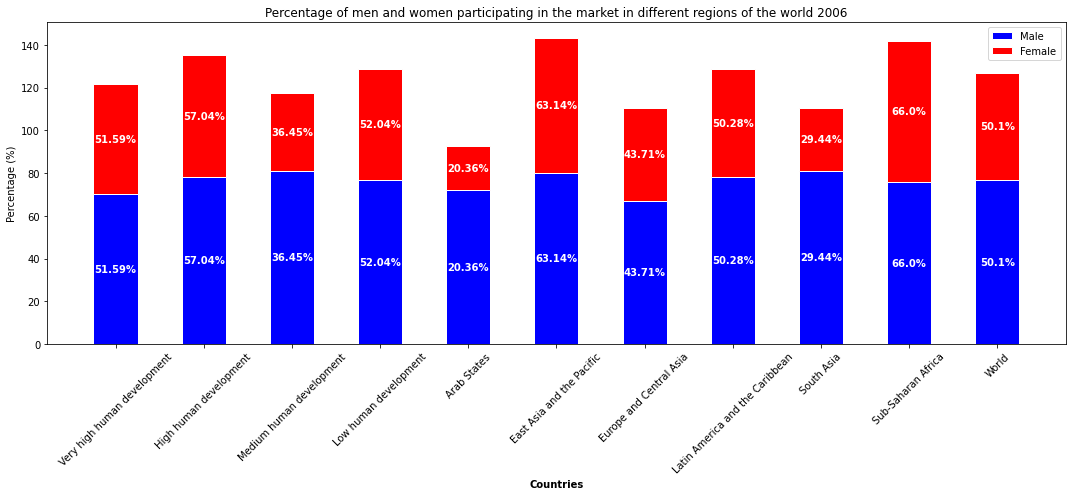

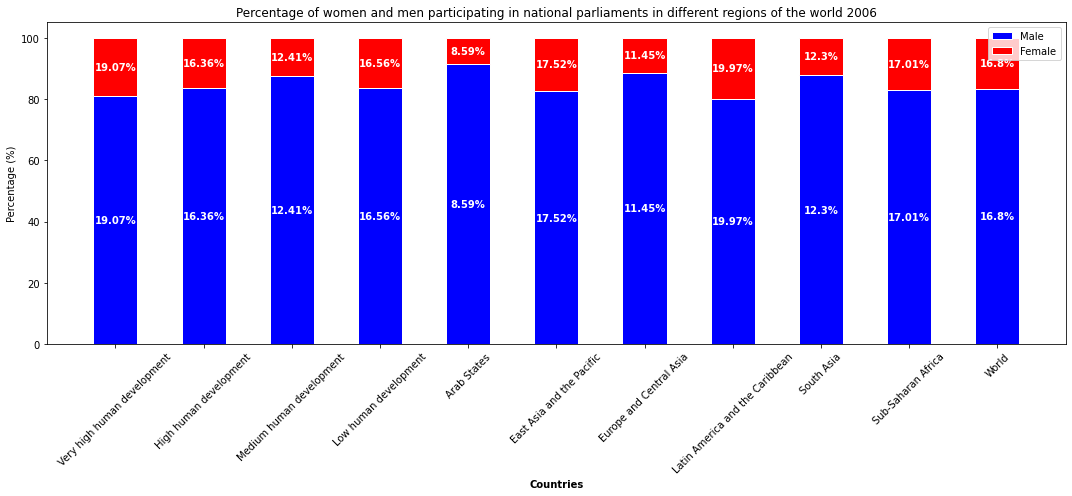

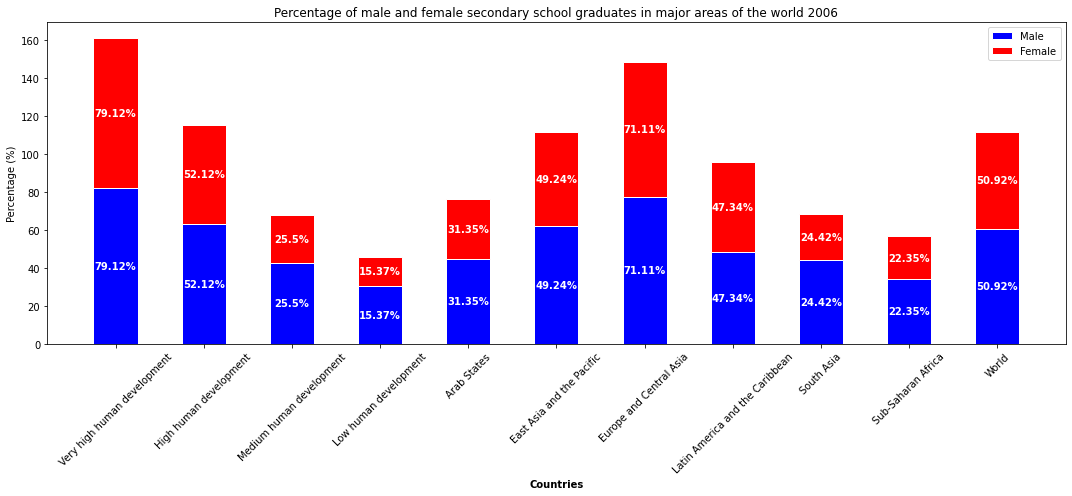

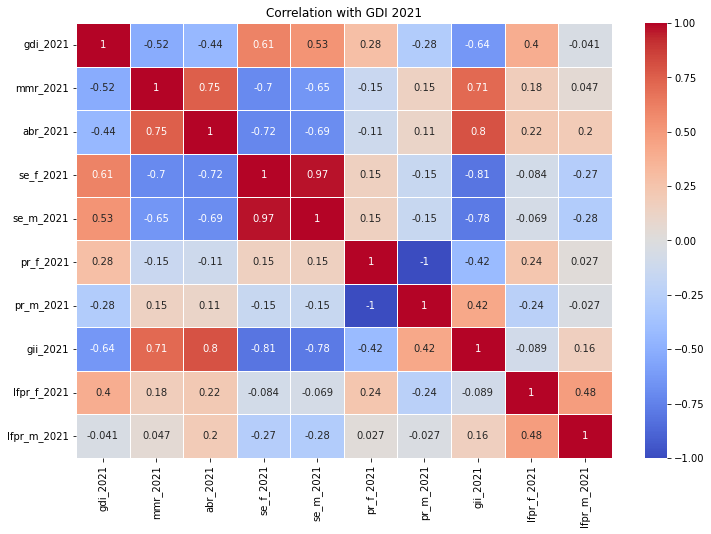

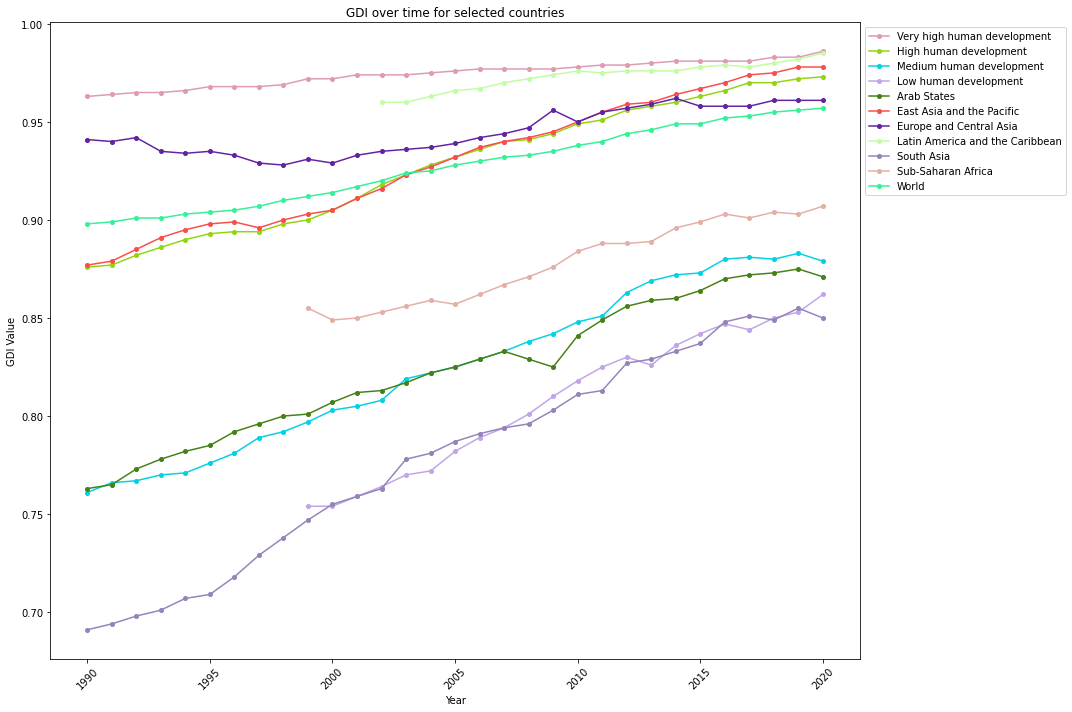

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

spark = SparkSession.builder.appName("GIIAnalysis").getOrCreate()

def read_csv(filename):
    try:
        df = spark.read.csv(filename, header=True, inferSchema=True)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def plot_correlation_heatmap(df, year):
    columns_of_interest = [
        f'gdi_{year}',
        f'mmr_{year}',
        f'abr_{year}',
        f'se_f_{year}',
        f'se_m_{year}',
        f'pr_f_{year}',
        f'pr_m_{year}',
        f'gii_{year}',
        f'lfpr_f_{year}',
        f'lfpr_m_{year}'
    ]
    
    df_subset = df.select(columns_of_interest)

    correlation_matrix = df_subset.toPandas().corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=.5)
    plt.title(f"Correlation with GDI {year}")
    plt.show()

def plot_gii_time_scatter_selected_countries(df):
    selected_countries = [
        "Very high human development",
        "High human development",
        "Medium human development",
        "Low human development",
        "Arab States",
        "East Asia and the Pacific",
        "Europe and Central Asia",
        "Latin America and the Caribbean",
        "South Asia",
        "Sub-Saharan Africa",
        "World"
    ]
    
    df_melted = df.select('country', *[f'gdi_{year}' for year in range(1990, 2021)]).toPandas()
    df_melted = pd.melt(df_melted, id_vars=['country'], value_vars=[f'gdi_{year}' for year in range(1990, 2021)], var_name='year', value_name='gdi')
    
    df_melted['year'] = df_melted['year'].str[-4:].astype(int)
    df_melted.dropna(inplace=True)

    plt.figure(figsize=(15,10))
    for country in selected_countries:
        if country in df_melted['country'].unique():
            country_data = df_melted[df_melted['country'] == country].sort_values('year')
        
            consecutive_groups = np.split(country_data, np.where(np.diff(country_data['year']) != 1)[0]+1)
            for group in consecutive_groups:
                plt.plot(group['year'], group['gdi'], label=country, marker='o', markersize=4, linestyle='-', color=np.random.rand(3,))
            
    plt.title('GDI over time for selected countries')
    plt.xlabel('Year')
    plt.ylabel('GDI Value')
    plt.xticks(rotation=45)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    filename = "Alldata.csv"
    df = read_csv(filename)
    if df is not None:
        plot_correlation_heatmap(df, 2021)
        plot_gii_time_scatter_selected_countries(df)

        

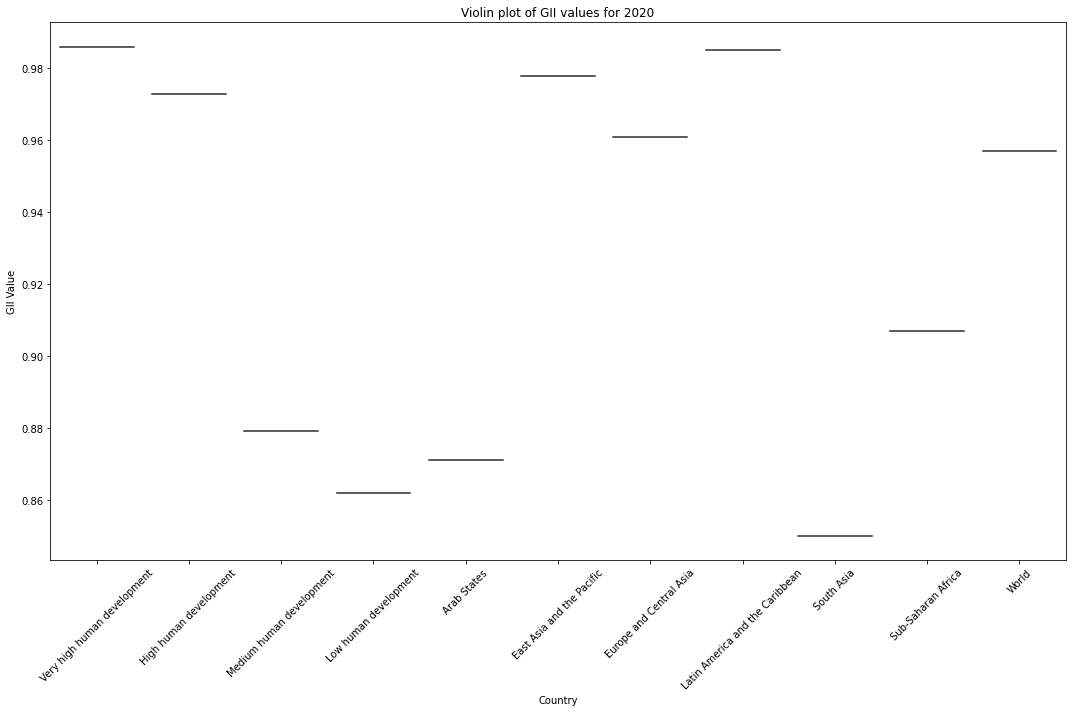

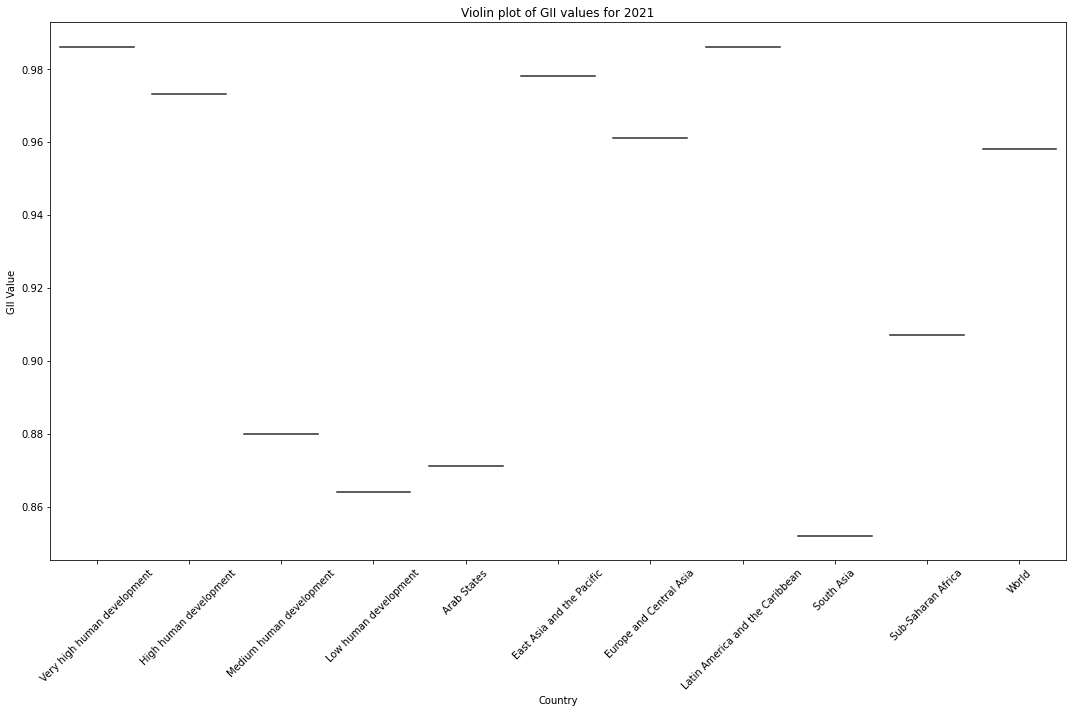

In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName("GIIAnalysis").getOrCreate()

def read_csv(filename):
    try:
        df = spark.read.csv(filename, header=True, inferSchema=True)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def plot_gii_violin_for_selected_countries(df, selected_countries, start_year, end_year):

    for year in range(start_year, end_year + 1):  
        gii_column = f'gdi_{year}'
        if gii_column not in df.columns:
            continue

        data_subset = df.select('country', gii_column).na.drop()
    
 
        data_subset = data_subset.filter(col('country').isin(selected_countries))
    
        plt.figure(figsize=(15, 10))
        sns.violinplot(x="country", y=gii_column, data=data_subset.toPandas(), inner="quartile", palette="viridis")
    
        plt.xticks(rotation=45)
        plt.title(f"Violin plot of GII values for {year}")
        plt.ylabel("GII Value")
        plt.xlabel("Country")
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    filename = "Alldata.csv"
    df = read_csv(filename)
    
    if df is not None:
        selected_countries = [
            "Very high human development",
            "High human development",
            "Medium human development",
            "Low human development",
            "Arab States",
            "East Asia and the Pacific",
            "Europe and Central Asia",
            "Latin America and the Caribbean",
            "South Asia",
            "Sub-Saharan Africa",
            "World"
        ]
        start_year = 2020
        end_year = 2021
        plot_gii_violin_for_selected_countries(df, selected_countries, start_year, end_year)


           

# 2.4

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
import pandas as pd

# 创建Spark会话
spark = SparkSession.builder.appName("GIIAnalysis").getOrCreate()

def read_csv(filename):
    try:
        df = spark.read.csv(filename, header=True, inferSchema=True)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def validate_data_quality(df):
    # 融化DataFrame以便进行数据质量验证
    df_melted = df.selectExpr("country", "stack(32, 'gii_1990', gii_1990, 'gii_1991', gii_1991, 'gii_1992', gii_1992, 'gii_1993', gii_1993, 'gii_1994', gii_1994, 'gii_1995', gii_1995, 'gii_1996', gii_1996, 'gii_1997', gii_1997, 'gii_1998', gii_1998, 'gii_1999', gii_1999, 'gii_2000', gii_2000, 'gii_2001', gii_2001, 'gii_2002', gii_2002, 'gii_2003', gii_2003, 'gii_2004', gii_2004, 'gii_2005', gii_2005, 'gii_2006', gii_2006, 'gii_2007', gii_2007, 'gii_2008', gii_2008, 'gii_2009', gii_2009, 'gii_2010', gii_2010, 'gii_2011', gii_2011, 'gii_2012', gii_2012, 'gii_2013', gii_2013, 'gii_2014', gii_2014, 'gii_2015', gii_2015, 'gii_2016', gii_2016, 'gii_2017', gii_2017, 'gii_2018', gii_2018, 'gii_2019', gii_2019, 'gii_2020', gii_2020, 'gii_2021', gii_2021) as (year, gii)")
    
    # 去除缺失值
    df_melted = df_melted.filter(df_melted["gii"].isNotNull())
    
    # 保存数据
    df_melted.write.mode("overwrite").csv("validated_data.csv", header=True)

    # 计算缺失值百分比
    missing_percentage = (1 - (df_melted.count() / (32 * df.count()))) * 100
    print("Percentage of Missing Values for GII:", missing_percentage, "\n")
    
    # 获取列的数据类型
    data_types = df_melted.dtypes
    print("Data Types:\n", data_types, "\n")
    
    # 查找重复行
    duplicate_rows = df_melted.groupBy(df_melted.columns).count().filter(col("count") > 1).count()
    duplicate_percentage = (duplicate_rows / df_melted.count()) * 100
    print(f"Percentage of duplicate rows: {duplicate_percentage:.2f}%\n")

    return {
        "missing_percentage": missing_percentage,
        "data_types": data_types,
        "duplicate_percentage": duplicate_percentage
    }

if __name__ == '__main__':
    filename = "Alldata.csv"
    df = read_csv(filename)
    if df is not None:
        validate_data_quality(df)


Percentage of Missing Values for GII: 21.040655339805824 

Data Types:
 [('country', 'string'), ('year', 'string'), ('gii', 'double')] 

Percentage of duplicate rows: 0.00%



In [19]:
import pandas as pd

def read_csv(filename):
    try:
        df = pd.read_csv(filename)
        return df
    except FileNotFoundError:
        print(f"File {filename} not found!")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def validate_data_quality(df):
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    print("Data quality Report:")
    print("===================")
    for column, missing_count in missing_values.items():
        percent = missing_percentage[column]
        print(f"{column}: {missing_count} missing values ({percent:.2f}%)")
    return {
        "missing_values": missing_values,
        "missing_percentage": missing_percentage
    }

if __name__ == '__main__':
    filename = "bestdata.csv"
    df = read_csv(filename)
    if df is not None:
        validate_data_quality(df)

Data quality Report:
country: 0 missing values (0.00%)
year: 0 missing values (0.00%)
se_f: 0 missing values (0.00%)
se_m: 0 missing values (0.00%)
pr_m: 0 missing values (0.00%)
abr: 0 missing values (0.00%)
lfpr_f: 0 missing values (0.00%)
lfpr_m: 0 missing values (0.00%)
gii: 0 missing values (0.00%)
pr_f: 0 missing values (0.00%)
mmr: 0 missing values (0.00%)
gdi: 0 missing values (0.00%)
